# 2D convolution network applied to over 60k images of dice

In [1]:
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import backend as K
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from PIL import Image

import numpy as np
from numpy.testing import assert_allclose, assert_equal
import matplotlib
import matplotlib.pyplot as plt
import os

# initialization and check if dataset got proper size

path = '/home/ubuntu/notebooks/photos/'
listing = os.listdir(path)

num_samples = 0
for i in range(1, 7):
    num_samples += len(os.listdir(path+str(i)))
assert_equal(60480, num_samples)
print(num_samples)

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


60480


In [2]:
# load all data into numpy array
immatrix = np.array(
    [np.array(Image.open(path+str(i) + '/' + file)).flatten() 
         for i in range(1, 7) 
             for file in os.listdir(path+str(i))], 'f')

In [3]:
print(immatrix.shape)

(60480, 4096)


In [4]:
# create labels for data in array
labels = np.ones((num_samples, ), dtype=int)
counter = 0
for i in range(0, 60480, 10080):
    labels[i:i+10080] = counter
    counter +=1

In [5]:
# randomize data with const random_state
data, label = shuffle(immatrix, labels, random_state=8)

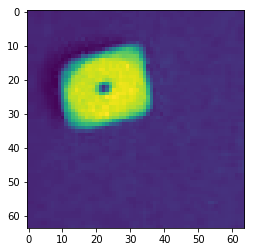

In [6]:
# show randomly chosen image
rows, cols = 64, 64
labels_values = 6
train_data = [data, label]
img=immatrix[2018].reshape(rows, cols)
plt.imshow(img)

In [7]:
(X, y) = (train_data[0], train_data[1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [8]:
# reshape to [color_layers][pixels_height][pixels_width], color_layers equal to 2 because photos are in GRAYSCALE
X_train = X_train.reshape(X_train.shape[0], 1, rows, cols).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, rows, cols).astype('float32')

# normalize to 0-1
X_train /= 255
X_test /= 255

print(X_train.shape, X_test.shape)

(48384, 1, 64, 64) (12096, 1, 64, 64)


In [9]:
# onehot
y_train = to_categorical(y_train, 6)
y_test = to_categorical(y_test, 6)
print(y_train.shape, y_test.shape)

(48384, 6) (12096, 6)


In [10]:
# create sequential model with 2NN layers
def base_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), input_shape=(1, 64, 64), data_format='channels_first', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(labels_values, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
# summarize model and apply checkpoints
model = base_model()
print(model.summary())
filepath = 'model-{epoch:02d}-{loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 60, 60)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 30, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 28, 32)        17312     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 14, 32)        0         
_______________________________________________________

In [12]:
# visualization of a model
plot_model(model, to_file='dice_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=72, verbose=1, callbacks=callbacks_list)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 48384 samples, validate on 12096 samples
Epoch 1/25
48384/48384 [==============================] - 28s 577us/step - loss: 0.8284 - acc: 0.6198 - val_loss: 0.2469 - val_acc: 0.9102
Epoch 2/25
48384/48384 [==============================] - 25s 524us/step - loss: 0.1665 - acc: 0.9401 - val_loss: 0.0405 - val_acc: 0.9874
Epoch 3/25
48384/48384 [==============================] - 25s 524us/step - loss: 0.0652 - acc: 0.9781 - val_loss: 0.0717 - val_acc: 0.9730
Epoch 4/25
48384/48384 [==============================] - 25s 524us/step - loss: 0.0417 - acc: 0.9854 - val_loss: 0.0388 - val_acc: 0.9864
Epoch 5/25
48384/48384 [==============================] - 25s 524us/step - loss: 0.0340 - acc: 0.9890 - val_loss: 0.0210 - val_acc: 0.9930
Epoch 6/25
48384/48384 [==============================] - 25s 522us/step - loss: 0.0377 - acc: 0.9873 - val_loss: 0.0117 - val_acc: 0.9967
Epoch 7/25
48384/48384 [==============================] - 25s 524us/step - loss: 0.0218 - acc: 0.9927 - val_loss: 0.

In [16]:
print(history.history.keys())
print("Accuracy: %.2f%%" % (score[1]*100))
print('Test loss:', score[0])
print('Test accuracy', score[1])

dict_keys(['acc', 'loss', 'val_loss', 'val_acc'])
Accuracy: 99.88%
Test loss: 0.00420372898561561
Test accuracy 0.9988425925925926


In [17]:
print('training results:')
for i in range(len(model.metrics_names)):
    print(str(model.metrics_names[i]) + ": " + str(score[i]))

training results:
loss: 0.00420372898561561
acc: 0.9988425925925926


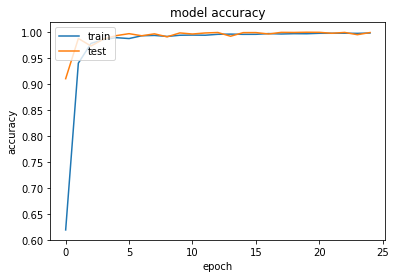

In [19]:
#summarize for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

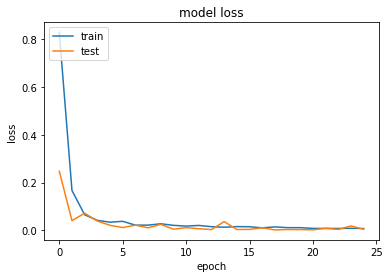

In [20]:
#summarize for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
model_json = model.to_json()
with open('dice_model.json', 'w') as json_file:
    json_file.write(model_json)
    
model.save_weights('dice_weights.h5')
print('Saved model weights')

Saved model weights


In [24]:
new_model = load_model('model-25-0.0074.h5')
# check in models are similar to the given tolerance
assert_allclose(model.predict(X_train),
               new_model.predict(X_train),
               1e-4)

In [25]:
filepath = 'model_continue-{epoch:02d}-{loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
new_history = new_model.fit(X_train, y_train, epochs=10, batch_size=72, callbacks=callbacks_list)

Epoch 1/10
48384/48384 [==============================] - 24s 494us/step - loss: 0.0099 - acc: 0.9972
Epoch 2/10
48384/48384 [==============================] - 24s 490us/step - loss: 0.0095 - acc: 0.9973
Epoch 3/10
48384/48384 [==============================] - 24s 489us/step - loss: 0.0056 - acc: 0.9984
Epoch 4/10
48384/48384 [==============================] - 24s 488us/step - loss: 0.0076 - acc: 0.9976
Epoch 5/10
48384/48384 [==============================] - 24s 488us/step - loss: 0.0069 - acc: 0.9981
Epoch 6/10
48384/48384 [==============================] - 24s 488us/step - loss: 0.0098 - acc: 0.9971
Epoch 7/10
48384/48384 [==============================] - 24s 488us/step - loss: 0.0066 - acc: 0.9982
Epoch 8/10
48384/48384 [==============================] - 24s 488us/step - loss: 0.0074 - acc: 0.9982
Epoch 9/10
48384/48384 [==============================] - 24s 488us/step - loss: 0.0065 - acc: 0.9982
Epoch 10/10
48384/48384 [==============================] - 24s 490us/step - loss: 

In [27]:
new_score = new_model.evaluate(X_test, y_test, verbose=1)
print('training results:')
for i in range(len(new_model.metrics_names)):
    print(str(new_model.metrics_names[i]) + ": " + str(new_score[i]))


12096/12096 [==============================] - 2s 166us/step
training results:
loss: 0.0050289289815833235
acc: 0.9984292328042328


In [28]:
model_json = model.to_json()
with open('dice_model_continue.json', 'w') as json_file:
    json_file.write(model_json)
    
model.save_weights('dice_weights_continue.h5')
print('Saved model weights')

Saved model weights


In [ ]:
new_model_2 = load_model('dice/model_continue-10-0.0030.h5')
# check in models are similar to the given tolerance
# assert_allclose(model.predict(X_train),
#                new_model.predict(X_train),
#                1e-4)

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [22]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [23]:
# plot_model_history(new_model_2)
# compute test accuracy
print (("Accuracy on test data is: %0.2f") % accuracy(X_test,y_test, model))

Accuracy on test data is: 99.88
